In [53]:
import psycopg2 as ps
import pandas as pd

conn = ps.connect(host="localhost", port = 5432, database="orioks", user="postgres", password="123")

In [31]:
def make_request(query):
    cursor = conn.cursor()
    cursor.execute(query)
    conn.commit()
    cursor.close()


In [32]:
def make_request_and_fetch(query):
    cursor = conn.cursor()
    cursor.execute(query)
    analysis_results = cursor.fetchall()
    print(analysis_results)
    for row in analysis_results:
        print(row[0])
    cursor.close()

## Задание 1

Напишите скрипт, выводящий количество всех оценок 5, 4, 3, 2 в единой таблице

In [33]:


plpgsql_script = """
CREATE OR REPLACE FUNCTION count_marks()
RETURNS TABLE(
    mark_value INTEGER,
    count_of_marks BIGINT
) AS $$
BEGIN
    RETURN QUERY
    SELECT mark, COUNT(*)::BIGINT
    FROM field_comprehension
    WHERE mark IN (5, 4, 3, 2)
    GROUP BY mark
    ORDER BY mark;
END;
$$ LANGUAGE plpgsql;
"""

make_request(plpgsql_script)


make_request_and_fetch("SELECT * FROM count_marks();")

[(2, 38), (3, 1217), (4, 1216), (5, 1339)]
2
3
4
5


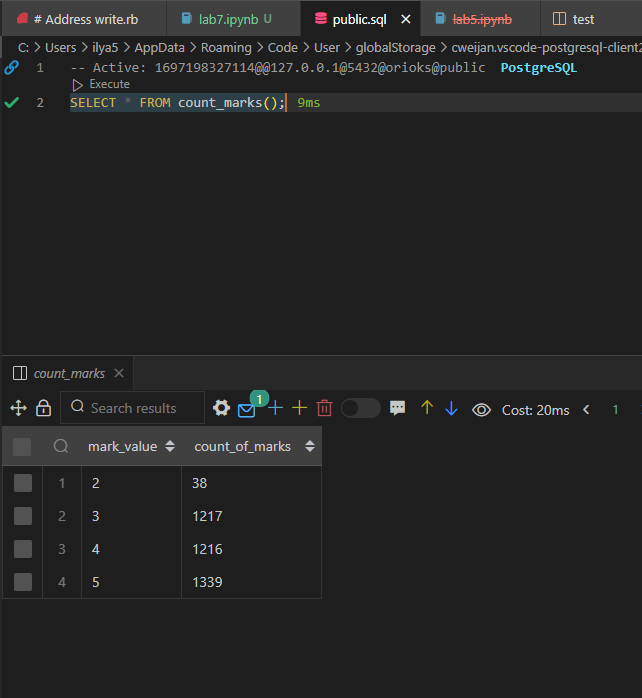

## Задание 2

In [54]:

plpgsql_script = """
CREATE OR REPLACE PROCEDURE add_professor(
    p_professor_id INTEGER,
    p_surname VARCHAR,
    p_name VARCHAR,
    p_patronymic VARCHAR,
    p_degree VARCHAR,
    p_academic_title VARCHAR,
    p_current_position VARCHAR,
    p_experience INTEGER,
    p_salary MONEY,
    p_structural_unit_number INTEGER,
    p_contract_number INTEGER,
    p_wage_rate NUMERIC
)
LANGUAGE plpgsql
AS $$
BEGIN
    INSERT INTO public.professor (professor_id, surname, name, patronymic, degree, academic_title, current_position, experience, salary)
    VALUES (p_professor_id, p_surname, p_name, p_patronymic, p_degree, p_academic_title, p_current_position, p_experience, p_salary);
    
    INSERT INTO employment (structural_unit_number, professor_id, contract_number, wage_rate)
    VALUES (p_structural_unit_number, p_professor_id, p_contract_number, p_wage_rate);
END;
$$;
"""
make_request(plpgsql_script)


In [51]:
make_request("CALL add_professor(81002::integer, 'Иванов'::varchar, 'Иванов'::varchar, 'Иванович'::varchar, 'доцент'::varchar, 'доцент'::varchar, 'доцент'::varchar, 2::integer, 23000::money, 1::integer, 42892::integer, 1::numeric);")

InFailedSqlTransaction: ОШИБКА:  текущая транзакция прервана, команды до конца блока транзакции игнорируются


## Задание 3

Сделайте функцию, которая выводит всю информацию о преподавателе по его id

In [37]:

plpgsql_script = """
CREATE OR REPLACE FUNCTION get_professor_info(p_professor_id INTEGER)
RETURNS TABLE (
    professor_id INTEGER,
    surname VARCHAR(30),
    name VARCHAR(30),
    patronymic VARCHAR(30),
    degree VARCHAR(15),
    academic_title VARCHAR(40),
    current_position VARCHAR(40),
    experience INTEGER,
    salary MONEY
)
LANGUAGE plpgsql
AS $$
BEGIN
    RETURN QUERY SELECT * FROM professor as pf WHERE pf.professor_id = p_professor_id;
END;
$$;
"""
make_request(plpgsql_script)

In [39]:

make_request_and_fetch("SELECT * FROM get_professor_info(81006);")

[(81006, 'Воронов', 'Николай', 'Михайлович', 'к.т.н.', 'доцент', 'доцент', 25, '98\xa0000,00 ?')]
81006


## Задание 4

Удаление преподавателя

In [58]:

plpgsql_script = """
CREATE OR REPLACE PROCEDURE delete_professor(p_professor_id INTEGER)
LANGUAGE plpgsql
AS $$
BEGIN
    DELETE FROM field_employers WHERE professor_id = p_professor_id;
    DELETE FROM employment WHERE professor_id = p_professor_id;
    DELETE FROM professor WHERE professor_id = p_professor_id;
END;
$$;
"""
make_request(plpgsql_script)

In [60]:

make_request_and_fetch("select * from professor where professor_id = 81002;")
make_request("CALL delete_professor(81002);")
make_request_and_fetch("select * from professor where professor_id = 81002;")

[(81002, 'Иванов', 'Иванов', 'Иванович', 'доцент', 'доцент', 'доцент', 2, '23\xa0000,00 ?')]
81002
[]


## Задание 5

Триггер на добавление должника

In [ ]:

"""
CREATE OR REPLACE FUNCTION check_and_add_debtor()
RETURNS TRIGGER AS $$
BEGIN
    IF NEW.mark = 2 THEN
        INSERT INTO debtors(student_id)
        VALUES (NEW.student_id);
    END IF;

    IF OLD.mark = 2 AND NEW.mark != 2 THEN
        DELETE FROM debtors WHERE student_id = NEW.student_id;
    END IF;

    RETURN NEW;
END;
$$ LANGUAGE plpgsql;

CREATE TRIGGER trigger_check_and_add_debtor
AFTER INSERT OR UPDATE OF mark ON field_comprehension
FOR EACH ROW EXECUTE FUNCTION check_and_add_debtor();

"""